In [7]:
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
from custom import custom_funcs as cf

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nodes and Edges: How do we represent relationships between individuals using NetworkX?

As mentioned earlier, networks, also known as graphs, are comprised of individual entities and their representatives. The technical term for these are nodes and edges, and when we draw them we typically use circles (nodes) and lines (edges). 

In this notebook, we will work with a social network of seventh graders, in which nodes are individual students, and edges represent their relationships. Edges between individuals show how often the seventh graders indicated other seventh graders as their favourite.

Data credit: http://konect.uni-koblenz.de/networks/moreno_seventh

## Data Representation

In the `networkx` implementation, graph objects store their data in dictionaries. 

Nodes are part of the attribute `Graph.node`, which is a dictionary where the key is the node ID and the values are a dictionary of attributes. 

Edges are part of the attribute `Graph.edge`, which is a nested dictionary. Data are accessed as such: `G.edge[node1][node2]['attr_name']`.

Because of the dictionary implementation of the graph, any hashable object can be a node. This means strings and tuples, but not lists and sets.

## Load Data

Let's load some real network data to get a feel for the NetworkX API. This [dataset](http://konect.uni-koblenz.de/networks/moreno_seventh) comes from a study of 7th grade students.

> This directed network contains proximity ratings between studetns from 29 seventh grade students from a school in Victoria. Among other questions the students were asked to nominate their preferred classmates for three different activities. A node represents a student. An edge between two nodes shows that the left student picked the right student as his answer. The edge weights are between 1 and 3 and show how often the left student chose the right student as his favourite.

In [8]:
G = cf.load_seventh_grader_network()

# Basic Network Statistics
Let's first understand how many students and friendships are represented in the network.

In [9]:
# Who are represented in the network?
G.nodes()[0:5]

[1, 2, 3, 4, 5]

### Exercise

Can you write a single line of code that returns the number of nodes in the graph?

In [10]:
len(G.nodes())
# len(G)

29

Let's now figure out who is connected to who in the network

In [11]:
# Who is connected to who in the network?
G.edges()[0:5]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]

### Exercise

Can you write a single line of code that returns the number of relationships represented?

In [12]:
 len(G.edges()) 

376

## Concept

A **network**, more technically known as a **graph**, is comprised of:

- a set of nodes
- joined by a set of edges

They can be represented as two lists:

1. A **node list**: a list of 2-tuples where the first element of each tuple is the representation of the node, and the second element is a dictionary of metadata associated with the node.
2. An **edge list**: a list of 3-tuples where the first two elements are the nodes that are connected together, and the third element is a dictionary of metadata associated with the edge.

Since this is a social network of people, there'll be attributes for each individual, such as a student's gender. We can grab that data off from the attributes that are stored with each node.

In [13]:
# Let's get a list of nodes with their attributes.
G.nodes(data=True)[0:5]

# NetworkX will return a list of tuples in the form (node_id, attribute_dictionary) 

[(1, {'gender': 'male'}),
 (2, {'gender': 'male'}),
 (3, {'gender': 'male'}),
 (4, {'gender': 'male'}),
 (5, {'gender': 'male'})]

### Exercise

Can you count how many males and females are represented in the graph?

Hint: You may want to use the Counter object from the collections module.

In [14]:
from collections import Counter
mf_counts = Counter([d['gender'] for n, d in G.nodes(data=True)])

def test_answer(mf_counts):
    assert mf_counts['female'] == 17
    assert mf_counts['male'] == 12
    
test_answer(mf_counts)

Edges can also store attributes in their attribute dictionary.

In [15]:
G.edges(data=True)[0:5]

[(1, 2, {'count': 1}),
 (1, 3, {'count': 1}),
 (1, 4, {'count': 2}),
 (1, 5, {'count': 2}),
 (1, 6, {'count': 3})]

In this synthetic social network, the number of times the left student indicated that the right student was their favourite is stored in the "count" variable.

### Exercise

Can you figure out the maximum times any student rated another student as their favourite?

In [16]:
# Answer
counts = [d['count'] for _, _, d in G.edges(data=True)]
maxcount = max(counts)

def test_maxcount(maxcount):
    assert maxcount == 3
    
test_maxcount(maxcount)

### Exercise

We found out that there are two individuals that we left out of the network, individual no. 30 and 31. They are one male (30) and one female (31), and they are a pair that just love hanging out with one another and with individual 7 (`count=3`), in both directions per pair. Add this information to the graph.

If you need more help, check out https://networkx.readthedocs.io/en/stable/tutorial/index.html

In [17]:
# Answer
G.add_node(30, gender='male')
G.add_node(31, gender='female')
G.add_edge(30, 31, count=3)
G.add_edge(31, 30, count=3)
G.add_edge(30, 7, count=3)
G.add_edge(7, 30, count=3)
G.add_edge(31, 7, count=3)
G.add_edge(7, 31, count=3)

Verify that you have added in the edges and nodes correctly by running the following cell.

In [18]:
def test_graph_integrity(G):
    assert 30 in G.nodes()
    assert 31 in G.nodes()
    assert G.node[30]['gender'] == 'male'
    assert G.node[31]['gender'] == 'female'
    assert G.has_edge(30, 31)
    assert G.has_edge(30, 7)
    assert G.has_edge(31, 7)
    assert G.edge[30][7]['count'] == 3
    assert G.edge[7][30]['count'] == 3
    assert G.edge[31][7]['count'] == 3
    assert G.edge[7][31]['count'] == 3
    assert G.edge[30][31]['count'] == 3
    assert G.edge[31][30]['count'] == 3
    print('All tests passed.')
    
test_graph_integrity(G)

All tests passed.


## Tests

A note about the tests: Testing is good practice when writing code. Well-crafted assertion statements help you program defensivel, by forcing you to explicitly state your assumptions about the code or data.

For more references on defensive programming, check out Software Carpentry's website: http://swcarpentry.github.io/python-novice-inflammation/08-defensive/

For more information on writing tests for your data, check out these slides from a lightning talk I gave at Boston Python and SciPy 2015: http://j.mp/data-test

# Coding Patterns

These are some recommended coding patterns when doing network analysis using NetworkX, which stem from my roughly two years of experience with the package.

## Iterating using List Comprehensions
I would recommend that you use the following for compactness: 

    [d['attr'] for n, d in G.nodes(data=True)]

And if the node is unimportant, you can do:

    [d['attr'] for _, d in G.nodes(data=True)]

## Iterating over Edges using List Comprehensions

A similar pattern can be used for edges:

    [n2 for n1, n2, d in G.edges(data=True)]

or

    [n2 for _, n2, d in G.edges(data=True)]

If the graph you are constructing is a directed graph, with a "source" and "sink" available, then I would recommend the following pattern:

    [(sc, sk) for sc, sk, d in G.edges(data=True)]

or 

    [d['attr'] for sc, sk, d in G.edges(data=True)]

# Drawing Graphs

As illustrated above, we can draw graphs using the `nx.draw()` function. The most popular format for drawing graphs is the **node-link diagram**.

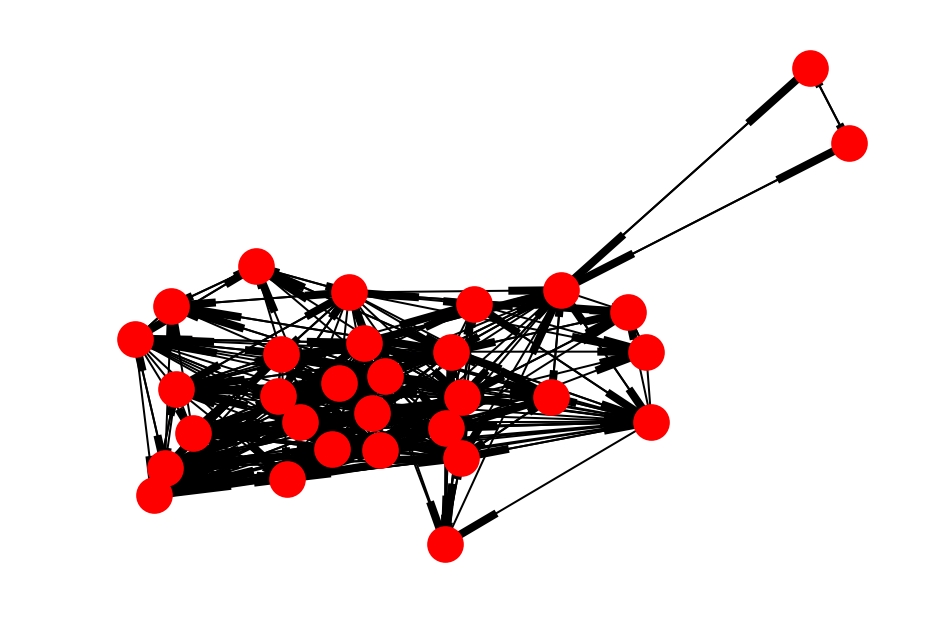

In [19]:
nx.draw(G)

If the network is small enough to visualize, and the node labels are small enough to fit in a circle, then you can use the `with_labels=True` argument.

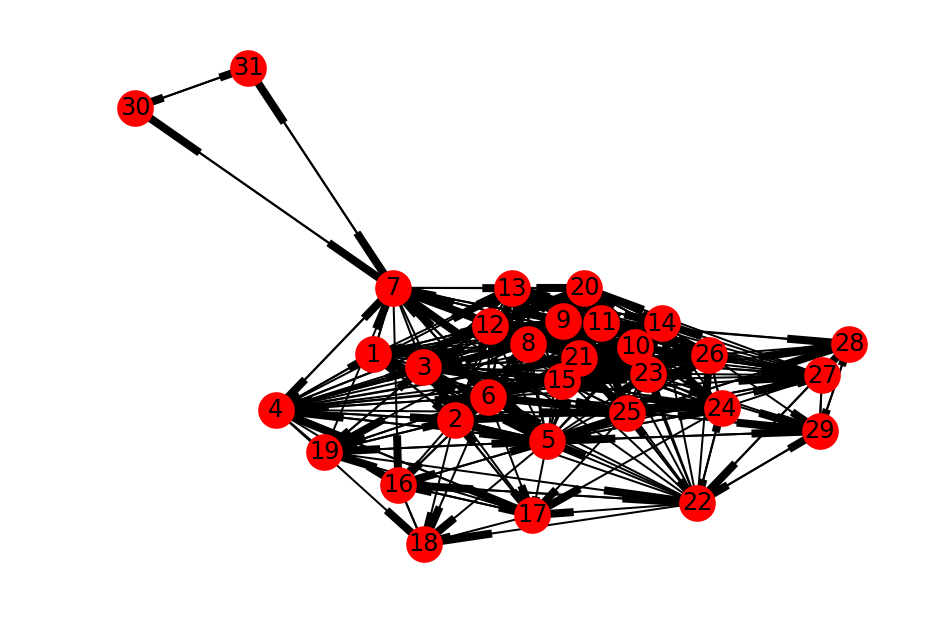

In [20]:
nx.draw(G, with_labels=True)

However, note that if the number of nodes in the graph gets really large, node-link diagrams can begin to look like massive hairballs. This is undesirable for graph visualization.

Instead, we can use a **matrix** to represent them. The nodes are on the x- and y- axes, and a filled square represent an edge between the nodes. This is done by using the `MatrixPlot` object from `nxviz`.

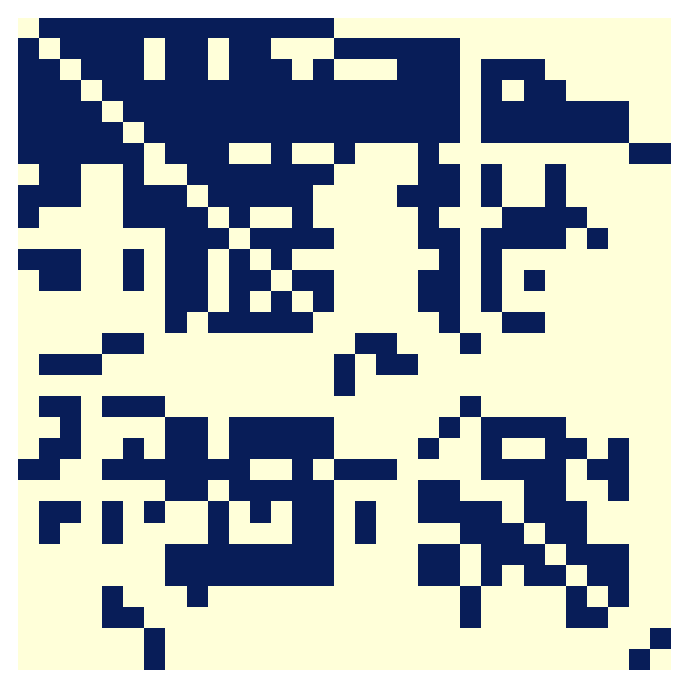

In [28]:
from nxviz import MatrixPlot

m = MatrixPlot(G)
m.draw()
plt.show()

Let's try another visualization, the **Circos plot**. We can order the nodes in the Circos plot according to the node ID, but any other ordering is possible as well. Edges are drawn between two nodes.

Credit goes to Justin Zabilansky (MIT) for the implementation, and Jon Charest for improvements.

In [25]:
from nxviz import CircosPlot

c = CircosPlot(G, node_color='gender', node_grouping='gender')
c.draw()
plt.savefig('images/seventh.png', dpi=300)

This visualization helps us highlight nodes that there are poorly connected, and others that are strongly connected.

Next up, let's try Hive Plots. HivePlots are not yet implemented in `nxviz` just yet, so we're going to be using the old API for this.

In [26]:
from hiveplot import HivePlot

nodes = dict()
nodes['male'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'male']
nodes['female'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'female']

edges = dict()
edges['group1'] = G.edges(data=True)

nodes_cmap = dict()
nodes_cmap['male'] = 'blue'
nodes_cmap['female'] = 'red'

edges_cmap = dict()
edges_cmap['group1'] = 'black'

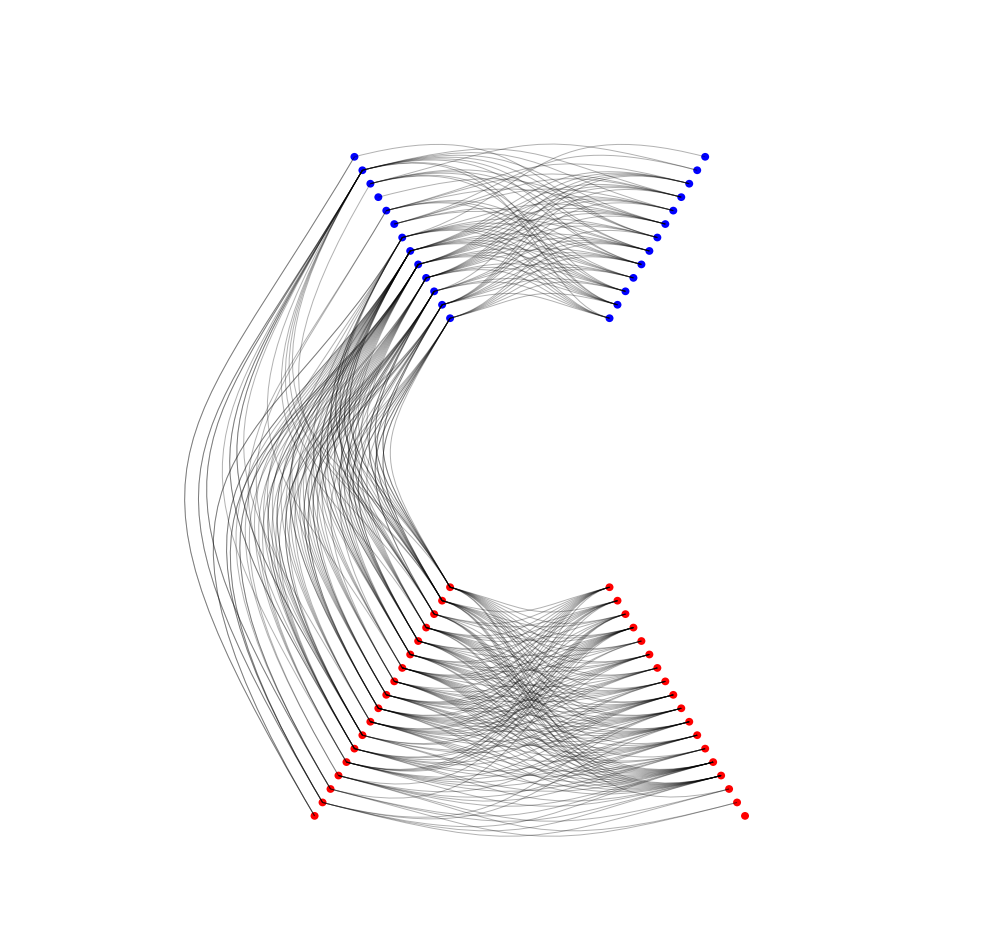

In [27]:
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.